Missing Values:
 Circuit_ID         0
Num_Gates          0
Gate_Types         0
Max_Path_Length    0
Logic_Depth        0
dtype: int64

Data Types:
 Circuit_ID          int64
Num_Gates           int64
Gate_Types         object
Max_Path_Length     int64
Logic_Depth         int64
dtype: object
RMSE: 1.5016
MAE: 1.1276
R-squared: 0.9795
CV RMSE: 1.7481 (std: 0.2972)


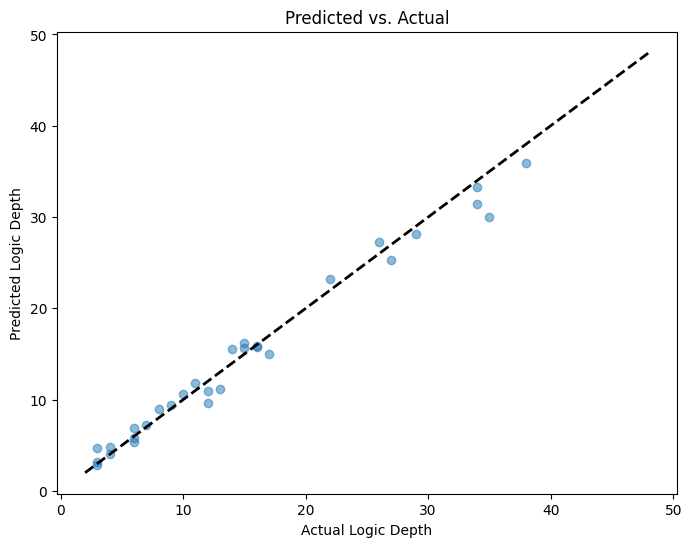

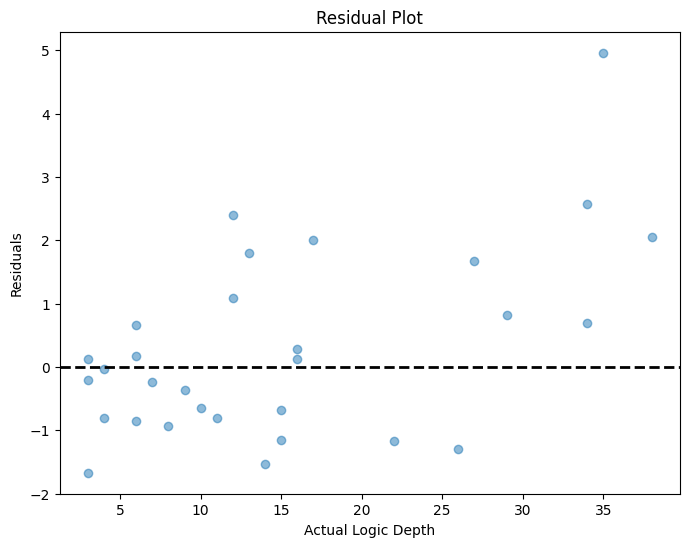

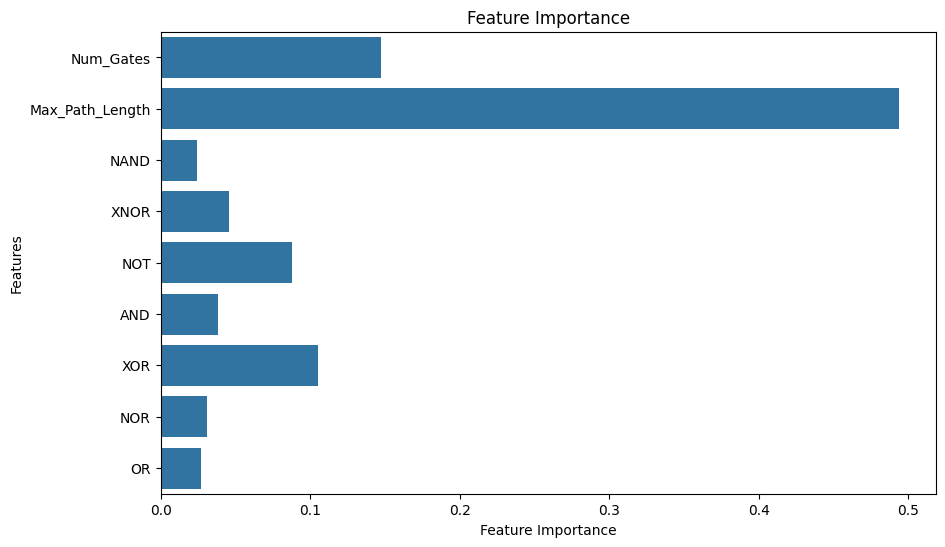


Predicted Logic Depth for New Data: 14.53


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# --- 1. Data Loading and Preprocessing ---

# Replace with your actual dataset path
DATASET_PATH = "/content/logic_depth_dataset.csv"  # MODIFY THIS!

try:
    data = pd.read_csv(DATASET_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {DATASET_PATH}.  Please check the path.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# --- 2. Data Validation and Cleaning ---

print("Missing Values:\n", data.isnull().sum())
data.dropna(inplace=True)  # Simple handling of missing values
print("\nData Types:\n", data.dtypes)

# Drop Circuit_ID
data.drop('Circuit_ID', axis=1, inplace=True)

# --- 3. Feature Engineering: One-Hot Encode Gate Types ---

def one_hot_encode_gates(gate_string):
    """Counts the occurrences of each gate type in a comma-separated string."""
    gate_counts = Counter(gate_string.split(','))
    return gate_counts

# Apply the function to create a Series of gate counts
gate_counts_series = data['Gate_Types'].apply(one_hot_encode_gates)

# Convert the Series of Counters to a DataFrame
gate_counts_df = pd.DataFrame(gate_counts_series.tolist()).fillna(0)

# Rename columns to be valid feature names (no commas, spaces, etc.)
gate_counts_df.columns = [col.replace(',', '').replace(' ', '_') for col in gate_counts_df.columns]

# Concatenate the one-hot encoded gates with the original DataFrame
data = pd.concat([data, gate_counts_df], axis=1)

# Drop the original 'Gate_Types' column
data.drop('Gate_Types', axis=1, inplace=True)


# --- 4. Feature Selection ---
# Get all one-hot encoded gate type columns
gate_type_features = list(gate_counts_df.columns)

features = ['Num_Gates', 'Max_Path_Length'] + gate_type_features
X = data[features]
y = data['Logic_Depth']

# --- 5. Data Scaling ---

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 6. Train-Test Split ---

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- 7. Model Training (XGBoost) ---

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# --- 8. Model Evaluation ---

y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

# --- 9. Cross-Validation ---

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"CV RMSE: {cv_rmse.mean():.4f} (std: {cv_rmse.std():.4f})")

# --- 10. Visualization ---

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Logic Depth")
plt.ylabel("Predicted Logic Depth")
plt.title("Predicted vs. Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.xlabel("Actual Logic Depth")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_model.feature_importances_, y=features)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()


# --- 11. Prediction on New Data (Example) ---
# Example:  A circuit with 30 gates, max path 15, and specific gate counts
new_data_dict = {
    'Num_Gates': [30],
    'Max_Path_Length': [15],
    'NAND': [10],
    'XNOR': [5],
    'NOT': [5],
    'AND': [5],
    'OR': [3],
    'XOR': [2],
    'NOR': [0]  # Important: Include all gate types, even if count is 0
}

# Ensure all one-hot encoded columns are present, filling missing ones with 0
for col in gate_type_features:
    if col not in new_data_dict:
        new_data_dict[col] = [0]  # Default to 0 if the gate type isn't specified

new_data = pd.DataFrame(new_data_dict)
# Reorder columns to match the training data
new_data = new_data[features]
new_data_scaled = scaler.transform(new_data)
predicted_depth = xgb_model.predict(new_data_scaled)
print(f"\nPredicted Logic Depth for New Data: {predicted_depth[0]:.2f}")

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    max_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

# --- 1. Data Loading and Preprocessing ---

# Replace with your actual dataset path
DATASET_PATH = "/content/logic_depth_dataset.csv"  # MODIFY THIS!

try:
    data = pd.read_csv(DATASET_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {DATASET_PATH}.  Please check the path.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# --- 2. Data Validation and Cleaning ---
data.dropna(inplace=True)  # Simple handling of missing values
data.drop('Circuit_ID', axis=1, inplace=True)

# --- 3. Feature Engineering: Optimized One-Hot Encoding ---

# Use pandas get_dummies for *much* faster one-hot encoding.
# This is significantly more efficient than the previous Counter-based approach.
gate_types = data['Gate_Types'].str.get_dummies(sep=',')
# Clean column names (remove spaces, etc.)
gate_types.columns = [col.replace(' ', '_') for col in gate_types.columns]
data = pd.concat([data, gate_types], axis=1)
data.drop('Gate_Types', axis=1, inplace=True)

# --- 4. Feature Selection ---
gate_type_features = list(gate_types.columns)
features = ['Num_Gates', 'Max_Path_Length'] + gate_type_features
X = data[features]
y = data['Logic_Depth']

# --- 5. Data Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 6. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- 7. Model Training (XGBoost) with Early Stopping ---

# Use a smaller validation set for early stopping to speed up training.
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)  # 10% of training data for validation

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,  # Increased n_estimators, but we'll use early stopping
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,  # Use all cores
    early_stopping_rounds=50,  # Stop if validation loss doesn't improve for 50 rounds
)

start_time = time.time()  # Start timing

# Train with early stopping
xgb_model.fit(
    X_train_es,
    y_train_es,
    eval_set=[(X_val_es, y_val_es)],  # Pass validation set for early stopping
    verbose=False,  # Suppress verbose output during training
)

end_time = time.time()  # End timing
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# --- 8. Model Evaluation (Multiple Metrics) ---

y_pred = xgb_model.predict(X_test)

# Dictionary to store evaluation metrics
metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred),
    "R-squared": r2_score(y_test, y_pred),
    "Explained Variance": explained_variance_score(y_test, y_pred),
    "Max Error": max_error(y_test, y_pred),
}

print("\nEvaluation Metrics:")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

# --- 9. Cross-Validation (More Efficient) ---

# Use cross_validate for a more concise way to get multiple scores
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
cv_results = cross_validate(
    xgb_model, X_scaled, y, cv=5, scoring=scoring_metrics, n_jobs=-1
)

print("\nCross-Validation Results:")
print(f"  CV RMSE: {np.sqrt(-cv_results['test_neg_mean_squared_error'].mean()):.4f}")
print(f"  CV MAE: {-cv_results['test_neg_mean_absolute_error'].mean():.4f}")
print(f"  CV R-squared: {cv_results['test_r2'].mean():.4f}")

# --- 10. Visualization ---

# Predicted vs. Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Logic Depth")
plt.ylabel("Predicted Logic Depth")
plt.title("Predicted vs. Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.xlabel("Actual Logic Depth")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.show()

# Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_model.feature_importances_, y=features)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

# --- 11. Prediction on New Data (Example) ---

new_data_dict = {
    'Num_Gates': [30],
    'Max_Path_Length': [15],
    'NAND': [10],
    'XNOR': [5],
    'NOT': [5],
    'AND': [5],
    'OR': [3],
    'XOR': [2],
    'NOR': [0]
}

# Ensure all one-hot encoded columns are present
for col in gate_type_features:
    if col not in new_data_dict:
        new_data_dict[col] = [0]

new_data = pd.DataFrame(new_data_dict)
new_data = new_data[features]
new_data_scaled = scaler.transform(new_data)  # Scale the new data
predicted_depth = xgb_model.predict(new_data_scaled)
print(f"\nPredicted Logic Depth for New Data: {predicted_depth[0]:.2f}")

Training Time: 0.12 seconds

Evaluation Metrics:
RMSE: 1.0172
MAE: 0.6982
R-squared: 0.9906
Explained Variance: 0.9906
Max Error: 2.8616


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 1170, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/training.py", line 182, in train
    if cb_container.after_iteration(bst, i, dtrain, evals):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/callback.py", line 261, in after_iteration
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/callback.py", line 261, in <genexpr>
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/callback.py", line 446, in after_iteration
    raise ValueError(msg)
ValueError: Must have at least 1 validation dataset for early stopping.


Training Time: 0.09 seconds

Evaluation Metrics:
RMSE: 1.0172
MAE: 0.6982
R-squared: 0.9906
Explained Variance: 0.9906
Max Error: 2.8616

Cross-Validation Results:
  CV RMSE: 1.1859
  CV MAE: 0.7849
  CV R-squared: 0.9872


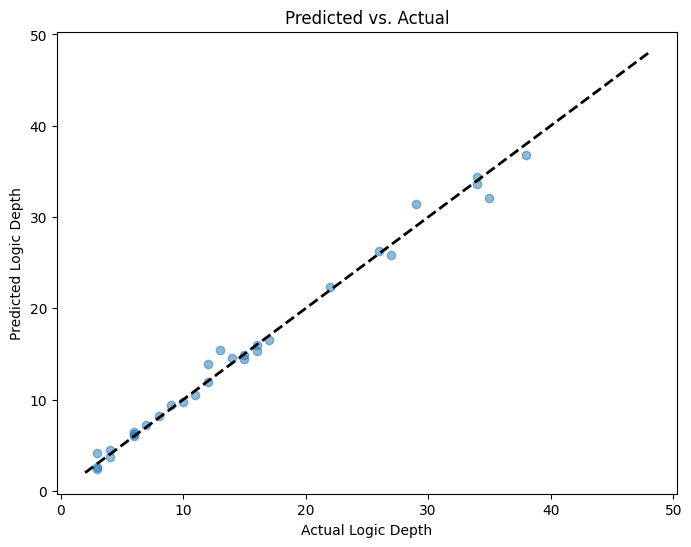

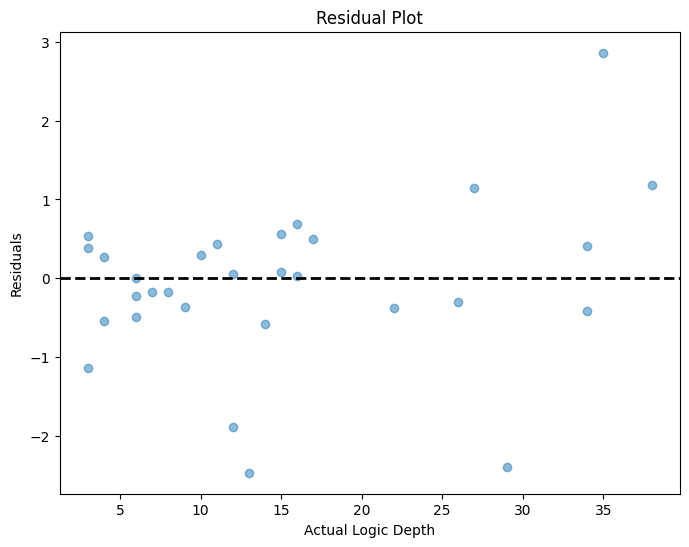

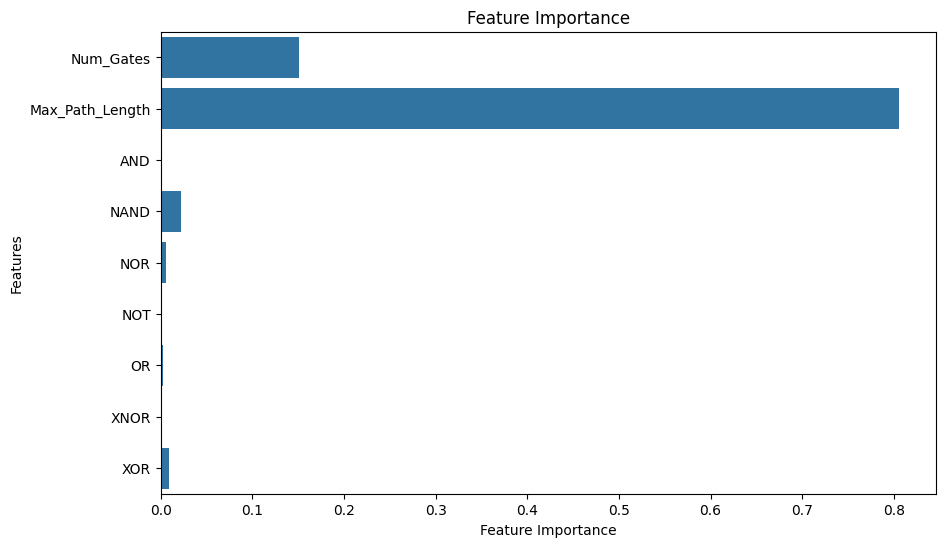


Predicted Logic Depth for New Data: 14.28


In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    max_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

# --- 1. Data Loading and Preprocessing ---

DATASET_PATH = "/content/logic_depth_dataset.csv"

try:
    data = pd.read_csv(DATASET_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {DATASET_PATH}.  Please check the path.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# --- 2. Data Validation and Cleaning ---
data.dropna(inplace=True)
data.drop('Circuit_ID', axis=1, inplace=True)

# --- 3. Feature Engineering: Optimized One-Hot Encoding ---
gate_types = data['Gate_Types'].str.get_dummies(sep=',')
gate_types.columns = [col.replace(' ', '_') for col in gate_types.columns]
data = pd.concat([data, gate_types], axis=1)
data.drop('Gate_Types', axis=1, inplace=True)

# --- 4. Feature Selection ---
gate_type_features = list(gate_types.columns)
features = ['Num_Gates', 'Max_Path_Length'] + gate_type_features
X = data[features]
y = data['Logic_Depth']

# --- 5. Data Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 6. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- 7. Model Training (XGBoost) with Early Stopping (on final model) ---

#  Validation set for early stopping *after* the main train/test split.
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
)

start_time = time.time()
xgb_model.fit(
    X_train_es,
    y_train_es,
    eval_set=[(X_val_es, y_val_es)],  # Validation set for early stopping
    verbose=False,
)
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")


# --- 8. Model Evaluation (Multiple Metrics) ---

y_pred = xgb_model.predict(X_test)
metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred),
    "R-squared": r2_score(y_test, y_pred),
    "Explained Variance": explained_variance_score(y_test, y_pred),
    "Max Error": max_error(y_test, y_pred),
}

print("\nEvaluation Metrics:")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

# --- 9. Cross-Validation (WITHOUT Early Stopping) ---

#  Remove early_stopping_rounds from the XGBRegressor *during* cross-validation.
xgb_model_cv = xgb.XGBRegressor(  # Create a *separate* instance for CV
    objective='reg:squarederror',
    n_estimators=100,  #  A reasonable number of estimators for CV
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    # NO early_stopping_rounds here!
)

scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
cv_results = cross_validate(
    xgb_model_cv, X_scaled, y, cv=5, scoring=scoring_metrics, n_jobs=-1
)

print("\nCross-Validation Results:")
print(f"  CV RMSE: {np.sqrt(-cv_results['test_neg_mean_squared_error'].mean()):.4f}")
print(f"  CV MAE: {-cv_results['test_neg_mean_absolute_error'].mean():.4f}")
print(f"  CV R-squared: {cv_results['test_r2'].mean():.4f}")

# --- 10. Visualization (Same as before) ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Logic Depth")
plt.ylabel("Predicted Logic Depth")
plt.title("Predicted vs. Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.xlabel("Actual Logic Depth")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_model.feature_importances_, y=features)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

# --- 11. Prediction on New Data (Same as before) ---
new_data_dict = {
    'Num_Gates': [30],
    'Max_Path_Length': [15],
    'NAND': [10],
    'XNOR': [5],
    'NOT': [5],
    'AND': [5],
    'OR': [3],
    'XOR': [2],
    'NOR': [0]
}

for col in gate_type_features:
    if col not in new_data_dict:
        new_data_dict[col] = [0]

new_data = pd.DataFrame(new_data_dict)
new_data = new_data[features]
new_data_scaled = scaler.transform(new_data)
predicted_depth = xgb_model.predict(new_data_scaled)
print(f"\nPredicted Logic Depth for New Data: {predicted_depth[0]:.2f}")